# 03A - Manual Baseline
This notebook creates a baseline model that is implemented manually by our team. The manual baseline algorithm randomly splits input data into 80% training and 20% testing. Let $\mu$ be the average rating in the dataset, $\mu_i$ be the average rating for user $i$, $b_i$ be the bias for user $i$, $\mu_j$ be the average rating for item $j$, $b_j$ be the bias for item $j$, and $\hat{r}_{ij}$ be the predicted rating for user $i$ item $j$. Then:
- $b_i = \mu_i - \mu$
- $b_u = \mu_b - \mu$
- $\hat{r}_{ij} = \mu + b_i + b_j$

The parameters $\mu$, $b_i$, and $b_j$ are all calculated from the training data, and used to generate predicted ratings for user-item pairs in the test set.

In [2]:
from surprise import Dataset, evaluate, SVD, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [3]:
# define file paths and read in the random samples

data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

Here we implement the above mentioned manual baseline model. Note that the function is written in a way that can be run for multiple iterations by giving the "in_tests" parameter a value higher than 1. By doing this we will be able generate a distribution of Mean Absolute Errors when the function finishes running.

In [4]:
def bias_baseline(in_df, in_tests):
    
    # accumulate a new MAE on each test
    mae_list = list()
    
    for i in range(in_tests):
        
        # input data is split into 80% training and 20% testing
        # we set a fixed seed for each iteration of shuffling
        shuffled_df = in_df.sample(frac=1, random_state=i)
        split_index = int(shuffled_df.shape[0] * 0.8)
        train_df = shuffled_df.iloc[0:split_index, :]
        test_df = shuffled_df.iloc[split_index:, :]
        
        overall_mean = train_df['overall'].mean()
        
        # calculate item biases (overall_mean - item_mean)
        item_means = train_df.groupby('asin').mean()
        item_biases = item_means['overall'] - overall_mean
        
        # calculate user biases (overall_mean - user_mean)
        user_means = train_df.groupby('reviewerID').mean()
        user_biases = user_means['overall'] - overall_mean
        
        # apply below function to each row in test_df
        def calc_abs_error(row):
            asin = row['asin']
            reviewerID = row['reviewerID']
            rating_actual = row['overall']
            
            user_bias = user_biases[reviewerID]
            item_bias = item_biases[asin]
            
            # calculate predicted rating and the absolute error
            rating_predicted = overall_mean + user_bias + item_bias
            abs_error = abs(rating_predicted - rating_actual)
            return abs_error
        
        # for each element in 'test', calculuate the absolute error 
        errors = test_df.apply(func = calc_abs_error, axis = 1)
        
        # calculate MAE and append
        mae = errors.mean()
        mae_list.append(mae)
        
    return np.array(mae_list)

In [5]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_baseline_man.array'), 'rb') as file_in:
        mae_list = pkl.load(file_in)
else:
    # using the largest sample, run the baseline model for 5 iterations and get 5 MAE's
    mae_list = bias_baseline(df_100, in_tests = 5)
    with open(os.path.join(data_path, 'results_baseline_man.array'), 'wb') as file_out:
          pkl.dump(mae_list, file_out)
        
print(mae_list)

[ 0.756029    0.75479449  0.75552996  0.75543144  0.75329674]


A list of MAE's are generated from the procedure above, and we make a box plot of these errors below. We can see that 25th - 75th percentiles lie between 0.7547 and 0.7556, and the median is about 0.7554. In later notebooks we shall compare the MAE generated from different models as a metric to measure model accuracy.

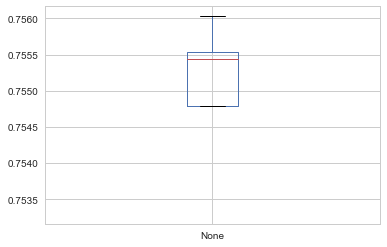

In [6]:
pd.Series(mae_list).plot(kind = 'box')

# Runtimes
In this part of the notebook, we run the baseline model with different sample sizes in order to explore how runtime scales as sample size increases. For each sample size, we run the baseline model for 1 iteration, and record the difference between start time and end time.

In [7]:
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_baseline_manual.list'), 'rb') as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:

        start = time.time()
        bias_baseline(df, in_tests = 1)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_baseline_manual.list'), 'wb') as file_out:
        pkl.dump(runtime_list, file_out)

Here we observe that, for our manual baseline model, the relationship between runtime and sample size is very close to linear. However, in actuality, for sufficiently dense data, we would expect time complexity to grow quadratically.

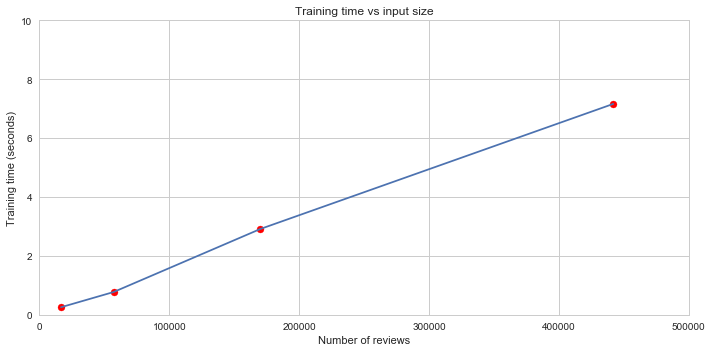

In [8]:
# plot runtime against sample size
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 10)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()